# Treasure Hunt Game Notebook

## Read and Review Your Starter Code
The theme of this project is a popular treasure hunt game in which the player needs to find the treasure before the pirate does. While you will not be developing the entire game, you will write the part of the game that represents the intelligent agent, which is a pirate in this case. The pirate will try to find the optimal path to the treasure using deep Q-learning. 

You have been provided with two Python classes and this notebook to help you with this assignment. The first class, TreasureMaze.py, represents the environment, which includes a maze object defined as a matrix. The second class, GameExperience.py, stores the episodes – that is, all the states that come in between the initial state and the terminal state. This is later used by the agent for learning by experience, called "exploration". This notebook shows how to play a game. Your task is to complete the deep Q-learning implementation for which a skeleton implementation has been provided. The code blocks you will need to complete has #TODO as a header.

First, read and review the next few code and instruction blocks to understand the code that you have been given.

In [46]:
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD , Adam, RMSprop
from keras.layers.advanced_activations import PReLU
import matplotlib.pyplot as plt
from TreasureMaze import TreasureMaze
from GameExperience import GameExperience
%matplotlib inline

The following code block contains an 8x8 matrix that will be used as a maze object:

In [47]:
maze = np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

This helper function allows a visual representation of the maze object:

In [48]:
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    pirate_row, pirate_col, _ = qmaze.state
    canvas[pirate_row, pirate_col] = 0.3   # pirate cell
    canvas[nrows-1, ncols-1] = 0.9 # treasure cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

The pirate agent can move in four directions: left, right, up, and down. 

While the agent primarily learns by experience through exploitation, often, the agent can choose to explore the environment to find previously undiscovered paths. This is called "exploration" and is defined by epsilon. This value is typically a lower value such as 0.1, which means for every ten attempts, the agent will attempt to learn by experience nine times and will randomly explore a new path one time. You are encouraged to try various values for the exploration factor and see how the algorithm performs.

In [49]:
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3


# Exploration factor
EPSILON_MIN = 0.1
EPSILON_START = 1.0
EPSILON_DECAY = 0.999

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)


The sample code block and output below show creating a maze object and performing one action (DOWN), which returns the reward. The resulting updated environment is visualized.

reward= -0.04


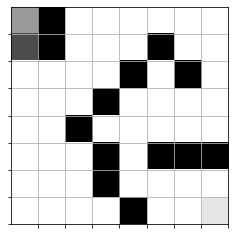

In [50]:
qmaze = TreasureMaze(maze)
canvas, reward, game_over = qmaze.act(DOWN)
print("reward=", reward)
show(qmaze)

This function simulates a full game based on the provided trained model. The other parameters include the TreasureMaze object and the starting position of the pirate.

In [51]:
def play_game(model, qmaze, pirate_cell):
    qmaze.reset(pirate_cell)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        # get next action
        q = model.predict(prev_envstate)
        action = np.argmax(q)

        # apply action, get rewards and new state
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            print("We won the game")
            return True
        elif game_status == 'lose':
            print("We lost the game")
            return False

This function helps you to determine whether the pirate can win any game at all. If your maze is not well designed, the pirate may not win any game at all. In this case, your training would not yield any result. The provided maze in this notebook ensures that there is a path to win and you can run this method to check.

In [52]:
def completion_check(model, qmaze):
    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            print("returning false because no valid actions in cell")
            return False
        if not play_game(model, qmaze, cell):
            print("returning false because did not win")
            return False
    return True

The code you have been given in this block will build the neural network model. Review the code and note the number of layers, as well as the activation, optimizer, and loss functions that are used to train the model.

In [53]:
def build_model(maze):
    model = Sequential()
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(PReLU())
    model.add(Dense(maze.size))
    model.add(PReLU())
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model

# #TODO: Complete the Q-Training Algorithm Code Block

This is your deep Q-learning implementation. The goal of your deep Q-learning implementation is to find the best possible navigation sequence that results in reaching the treasure cell while maximizing the reward. In your implementation, you need to determine the optimal number of epochs to achieve a 100% win rate.

You will need to complete the section starting with #pseudocode. The pseudocode has been included for you.

In [54]:
def qtrain(model, maze, **opt):

    # exploration factor
    global epsilon 

    # number of epochs
    n_epoch = opt.get('n_epoch', 15000)

    # maximum memory to store episodes
    max_memory = opt.get('max_memory', 1000)

    # maximum data size for training
    data_size = opt.get('data_size', 50)

    # start time
    start_time = datetime.datetime.now()

    # Construct environment/game from numpy array: maze (see above)
    qmaze = TreasureMaze(maze)

    # Initialize experience replay object
    experience = GameExperience(model, max_memory=max_memory)
    
    win_history = []   # history of win/lose game
    hsize = qmaze.maze.size//2   # history window size
    win_rate = 0.0
    epsilon = EPSILON_START # start at high exploration
    
    epoch = 0
    for i in range(n_epoch):
        agent_cell = qmaze.free_cells[random.randint(0, len(qmaze.free_cells) - 1)]
        print(agent_cell)
        qmaze.reset(agent_cell)
        envstate = qmaze.observe()
        game_status = 'not_over'
        n_episodes = 0
        while game_status == 'not_over':
            prev_envstate = envstate
            if random.random() < epsilon:
                # Do something random
                action = random.randint(0, num_actions - 1)
            else:
                # Predict next action
                q = experience.predict(prev_envstate)
                action = np.argmax(q)            
            
            envstate, reward, game_status = qmaze.act(action)
            episode = [prev_envstate, action, reward, envstate, game_status]
            experience.remember(episode)
            n_episodes += 1
            
        if game_status == 'win':
            win_history.append(1)
        else:
            win_history.append(0)
            
        win_rate = sum(win_history[-hsize:]) / hsize
        inputs, targets = experience.get_data(data_size)
        model.fit(inputs, targets, epochs=50, batch_size=25, verbose=0)
        loss = model.evaluate(inputs, targets)
        epsilon = max(EPSILON_MIN, EPSILON_START * (EPSILON_DECAY ** epoch))
        print(f"current epsilon: {epsilon}")
        epoch = i
        
                
            
        
        print(sum(win_history[-hsize:]), hsize)
    #Print the epoch, loss, episodes, win count, and win rate for each epoch
        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())
        template = "Epoch: {:03d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | time: {}"
        print(template.format(epoch, n_epoch-1, loss, n_episodes, sum(win_history), win_rate, t))
        # We simply check if training has exhausted all free cells and if in all
        # cases the agent won.
        if win_rate > 0.9 : epsilon = 0.05
        if sum(win_history[-hsize:]) == hsize and completion_check(model, qmaze):
            print("Reached 100%% win rate at epoch: %d" % (epoch,))
            break
    
    
    # Determine the total time for training
    dt = datetime.datetime.now() - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)

    print("n_epoch: %d, max_mem: %d, data: %d, time: %s" % (n_epoch, max_memory, data_size, t))
    return seconds

# This is a small utility for printing readable time strings:
def format_time(seconds):
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)

## Test Your Model

Now we will start testing the deep Q-learning implementation. To begin, select **Cell**, then **Run All** from the menu bar. This will run your notebook. As it runs, you should see output begin to appear beneath the next few cells. The code below creates an instance of TreasureMaze.

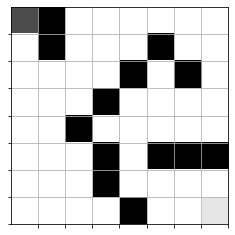

In [55]:
qmaze = TreasureMaze(maze)
show(qmaze)

In the next code block, you will build your model and train it using deep Q-learning. Note: This step takes several minutes to fully run.

In [56]:
model = build_model(maze)
qtrain(model, maze, epochs=1000, max_memory=8*maze.size, data_size=32)

(0, 5)
32/32 [==============================] - 0s 2ms/step
current epsilon: 1.0
0 32
Epoch: 000/14999 | Loss: 0.0764 | Episodes: 150 | Win count: 0 | Win rate: 0.000 | time: 2.5 seconds
(3, 1)
32/32 [==============================] - 0s 64us/step
current epsilon: 1.0
0 32
Epoch: 001/14999 | Loss: 0.0386 | Episodes: 137 | Win count: 0 | Win rate: 0.000 | time: 2.8 seconds
(1, 7)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.999
0 32
Epoch: 002/14999 | Loss: 0.0240 | Episodes: 151 | Win count: 0 | Win rate: 0.000 | time: 3.2 seconds
(4, 4)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.998001
1 32
Epoch: 003/14999 | Loss: 0.0238 | Episodes: 139 | Win count: 1 | Win rate: 0.031 | time: 3.6 seconds
(7, 2)
32/32 [==============================] - 0s 62us/step
current epsilon: 0.997002999
1 32
Epoch: 004/14999 | Loss: 0.0071 | Episodes: 148 | Win count: 1 | Win rate: 0.031 | time: 4.1 seconds
(1, 0)
32/32 [==============================] - 

32/32 [==============================] - 0s 161us/step
current epsilon: 0.9607702107358118
10 32
Epoch: 041/14999 | Loss: 0.0008 | Episodes: 14 | Win count: 13 | Win rate: 0.312 | time: 17.5 seconds
(2, 2)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.959809440525076
10 32
Epoch: 042/14999 | Loss: 0.0007 | Episodes: 144 | Win count: 13 | Win rate: 0.312 | time: 17.8 seconds
(4, 3)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.9588496310845509
10 32
Epoch: 043/14999 | Loss: 0.0086 | Episodes: 25 | Win count: 14 | Win rate: 0.312 | time: 18.1 seconds
(3, 0)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.9578907814534663
10 32
Epoch: 044/14999 | Loss: 0.0005 | Episodes: 140 | Win count: 14 | Win rate: 0.312 | time: 18.4 seconds
(0, 6)
32/32 [==============================] - 0s 64us/step
current epsilon: 0.9569328906720129
10 32
Epoch: 045/14999 | Loss: 0.0009 | Episodes: 100 | Win count: 15 | Win rate: 0.312 | t

current epsilon: 0.9230793978373362
3 32
Epoch: 081/14999 | Loss: 0.0021 | Episodes: 150 | Win count: 18 | Win rate: 0.094 | time: 32.8 seconds
(2, 2)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.9221563184394989
3 32
Epoch: 082/14999 | Loss: 0.0015 | Episodes: 146 | Win count: 18 | Win rate: 0.094 | time: 33.2 seconds
(6, 0)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.9212341621210594
2 32
Epoch: 083/14999 | Loss: 0.0016 | Episodes: 142 | Win count: 18 | Win rate: 0.062 | time: 33.5 seconds
(7, 2)
32/32 [==============================] - 0s 481us/step
current epsilon: 0.9203129279589383
2 32
Epoch: 084/14999 | Loss: 0.0010 | Episodes: 138 | Win count: 18 | Win rate: 0.062 | time: 34.0 seconds
(7, 3)
32/32 [==============================] - 0s 31us/step
current epsilon: 0.9193926150309794
2 32
Epoch: 085/14999 | Loss: 0.0014 | Episodes: 139 | Win count: 18 | Win rate: 0.062 | time: 34.4 seconds
(6, 0)
32/32 [=======================

32/32 [==============================] - 0s 0us/step
current epsilon: 0.8859803203984776
9 32
Epoch: 122/14999 | Loss: 0.0008 | Episodes: 138 | Win count: 27 | Win rate: 0.281 | time: 47.6 seconds
(7, 2)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.8850943400780792
9 32
Epoch: 123/14999 | Loss: 0.0007 | Episodes: 146 | Win count: 27 | Win rate: 0.281 | time: 48.0 seconds
(3, 1)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.8842092457380011
8 32
Epoch: 124/14999 | Loss: 0.0004 | Episodes: 141 | Win count: 27 | Win rate: 0.250 | time: 48.3 seconds
(3, 0)
32/32 [==============================] - 0s 67us/step
current epsilon: 0.8833250364922631
8 32
Epoch: 125/14999 | Loss: 0.0010 | Episodes: 149 | Win count: 27 | Win rate: 0.250 | time: 48.7 seconds
(7, 1)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.8824417114557709
8 32
Epoch: 126/14999 | Loss: 0.0010 | Episodes: 139 | Win count: 27 | Win rate: 0.250 | time:

current epsilon: 0.8512234991370274
8 32
Epoch: 162/14999 | Loss: 0.0005 | Episodes: 141 | Win count: 35 | Win rate: 0.250 | time: 61.9 seconds
(0, 3)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.8503722756378904
8 32
Epoch: 163/14999 | Loss: 0.0005 | Episodes: 135 | Win count: 35 | Win rate: 0.250 | time: 62.3 seconds
(0, 5)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.8495219033622525
7 32
Epoch: 164/14999 | Loss: 0.0005 | Episodes: 142 | Win count: 35 | Win rate: 0.219 | time: 62.6 seconds
(0, 5)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.8486723814588902
7 32
Epoch: 165/14999 | Loss: 0.0011 | Episodes: 144 | Win count: 35 | Win rate: 0.219 | time: 63.0 seconds
(0, 3)
32/32 [==============================] - 0s 63us/step
current epsilon: 0.8478237090774313
6 32
Epoch: 166/14999 | Loss: 0.0018 | Episodes: 144 | Win count: 35 | Win rate: 0.188 | time: 63.3 seconds
(2, 1)
32/32 [=========================

32/32 [==============================] - 0s 0us/step
current epsilon: 0.8170123504685077
13 32
Epoch: 203/14999 | Loss: 0.0011 | Episodes: 144 | Win count: 50 | Win rate: 0.406 | time: 76.2 seconds
(4, 1)
32/32 [==============================] - 0s 30us/step
current epsilon: 0.8161953381180392
13 32
Epoch: 204/14999 | Loss: 0.0018 | Episodes: 145 | Win count: 50 | Win rate: 0.406 | time: 76.6 seconds
(2, 1)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.8153791427799212
13 32
Epoch: 205/14999 | Loss: 0.0009 | Episodes: 139 | Win count: 50 | Win rate: 0.406 | time: 76.9 seconds
(7, 3)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.8145637636371413
12 32
Epoch: 206/14999 | Loss: 0.0001 | Episodes: 140 | Win count: 50 | Win rate: 0.375 | time: 77.3 seconds
(4, 1)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.8137491998735041
12 32
Epoch: 207/14999 | Loss: 0.0005 | Episodes: 149 | Win count: 50 | Win rate: 0.375 | 

current epsilon: 0.7849611281333891
7 32
Epoch: 243/14999 | Loss: 0.0013 | Episodes: 140 | Win count: 58 | Win rate: 0.219 | time: 91.0 seconds
(0, 3)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.7841761670052557
6 32
Epoch: 244/14999 | Loss: 0.0008 | Episodes: 134 | Win count: 58 | Win rate: 0.188 | time: 91.4 seconds
(1, 3)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.7833919908382505
6 32
Epoch: 245/14999 | Loss: 0.0010 | Episodes: 148 | Win count: 58 | Win rate: 0.188 | time: 91.8 seconds
(5, 4)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.7826085988474122
5 32
Epoch: 246/14999 | Loss: 0.0003 | Episodes: 155 | Win count: 58 | Win rate: 0.156 | time: 92.1 seconds
(0, 7)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.7818259902485648
5 32
Epoch: 247/14999 | Loss: 0.0007 | Episodes: 142 | Win count: 58 | Win rate: 0.156 | time: 92.6 seconds
(7, 6)
32/32 [==========================

32/32 [==============================] - 0s 0us/step
current epsilon: 0.7534131012276407
8 32
Epoch: 284/14999 | Loss: 0.0007 | Episodes: 150 | Win count: 67 | Win rate: 0.250 | time: 106.5 seconds
(7, 5)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.752659688126413
7 32
Epoch: 285/14999 | Loss: 0.0014 | Episodes: 140 | Win count: 67 | Win rate: 0.219 | time: 107.0 seconds
(4, 4)
32/32 [==============================] - 0s 64us/step
current epsilon: 0.7519070284382866
8 32
Epoch: 286/14999 | Loss: 0.0009 | Episodes: 15 | Win count: 68 | Win rate: 0.250 | time: 107.3 seconds
(5, 1)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.7511551214098483
8 32
Epoch: 287/14999 | Loss: 0.0010 | Episodes: 152 | Win count: 68 | Win rate: 0.250 | time: 107.6 seconds
(5, 4)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.7504039662884385
8 32
Epoch: 288/14999 | Loss: 0.0004 | Episodes: 145 | Win count: 68 | Win rate: 0.250 | tim

32/32 [==============================] - 0s 0us/step
current epsilon: 0.7238568640376019
11 32
Epoch: 324/14999 | Loss: 0.0008 | Episodes: 19 | Win count: 82 | Win rate: 0.344 | time: 120.4 seconds
(2, 0)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.7231330071735642
11 32
Epoch: 325/14999 | Loss: 0.0010 | Episodes: 130 | Win count: 82 | Win rate: 0.344 | time: 120.7 seconds
(6, 1)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.7224098741663907
10 32
Epoch: 326/14999 | Loss: 0.0011 | Episodes: 144 | Win count: 82 | Win rate: 0.312 | time: 121.1 seconds
(3, 1)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.7216874642922243
10 32
Epoch: 327/14999 | Loss: 0.0008 | Episodes: 140 | Win count: 82 | Win rate: 0.312 | time: 121.5 seconds
(0, 3)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.7209657768279321
10 32
Epoch: 328/14999 | Loss: 0.0008 | Episodes: 138 | Win count: 82 | Win rate: 0.312 

32/32 [==============================] - 0s 32us/step
current epsilon: 0.6954601118039706
7 32
Epoch: 364/14999 | Loss: 0.0012 | Episodes: 148 | Win count: 89 | Win rate: 0.219 | time: 135.4 seconds
(6, 7)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.6947646516921666
8 32
Epoch: 365/14999 | Loss: 0.0006 | Episodes: 1 | Win count: 90 | Win rate: 0.250 | time: 135.7 seconds
(1, 0)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.6940698870404745
8 32
Epoch: 366/14999 | Loss: 0.0007 | Episodes: 151 | Win count: 90 | Win rate: 0.250 | time: 136.1 seconds
(4, 1)
32/32 [==============================] - 0s 31us/step
current epsilon: 0.693375817153434
8 32
Epoch: 367/14999 | Loss: 0.0010 | Episodes: 138 | Win count: 90 | Win rate: 0.250 | time: 136.5 seconds
(7, 0)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.6926824413362805
7 32
Epoch: 368/14999 | Loss: 0.0006 | Episodes: 139 | Win count: 90 | Win rate: 0.219 | tim

32/32 [==============================] - 0s 0us/step
current epsilon: 0.668177358176252
12 32
Epoch: 404/14999 | Loss: 0.0004 | Episodes: 130 | Win count: 102 | Win rate: 0.375 | time: 150.4 seconds
(1, 4)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.6675091808180758
12 32
Epoch: 405/14999 | Loss: 0.0016 | Episodes: 143 | Win count: 102 | Win rate: 0.375 | time: 150.9 seconds
(0, 6)
32/32 [==============================] - 0s 31us/step
current epsilon: 0.6668416716372577
11 32
Epoch: 406/14999 | Loss: 0.0010 | Episodes: 140 | Win count: 102 | Win rate: 0.344 | time: 151.2 seconds
(6, 2)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.6661748299656204
11 32
Epoch: 407/14999 | Loss: 0.0005 | Episodes: 144 | Win count: 102 | Win rate: 0.344 | time: 151.6 seconds
(0, 2)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.6655086551356548
11 32
Epoch: 408/14999 | Loss: 0.0012 | Episodes: 148 | Win count: 103 | Win rate: 

32/32 [==============================] - 0s 0us/step
current epsilon: 0.6419649012238956
9 32
Epoch: 444/14999 | Loss: 0.0008 | Episodes: 144 | Win count: 114 | Win rate: 0.281 | time: 165.9 seconds
(5, 0)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.6413229363226718
9 32
Epoch: 445/14999 | Loss: 0.0004 | Episodes: 148 | Win count: 114 | Win rate: 0.281 | time: 166.2 seconds
(0, 0)
32/32 [==============================] - 0s 97us/step
current epsilon: 0.6406816133863491
9 32
Epoch: 446/14999 | Loss: 0.0002 | Episodes: 141 | Win count: 114 | Win rate: 0.281 | time: 166.6 seconds
(7, 3)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.6400409317729627
9 32
Epoch: 447/14999 | Loss: 0.0008 | Episodes: 137 | Win count: 114 | Win rate: 0.281 | time: 166.9 seconds
(1, 6)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.6394008908411898
10 32
Epoch: 448/14999 | Loss: 0.0012 | Episodes: 111 | Win count: 115 | Win rate: 0.3

32/32 [==============================] - 0s 0us/step
current epsilon: 0.6167807534338768
8 32
Epoch: 484/14999 | Loss: 0.0007 | Episodes: 141 | Win count: 127 | Win rate: 0.250 | time: 181.1 seconds
(4, 1)
32/32 [==============================] - 0s 32us/step
current epsilon: 0.6161639726804429
7 32
Epoch: 485/14999 | Loss: 0.0009 | Episodes: 139 | Win count: 127 | Win rate: 0.219 | time: 181.4 seconds
(0, 5)
32/32 [==============================] - 0s 31us/step
current epsilon: 0.6155478087077625
6 32
Epoch: 486/14999 | Loss: 0.0010 | Episodes: 139 | Win count: 127 | Win rate: 0.188 | time: 181.8 seconds
(0, 7)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.6149322608990547
5 32
Epoch: 487/14999 | Loss: 0.0005 | Episodes: 137 | Win count: 127 | Win rate: 0.156 | time: 182.1 seconds
(7, 0)
32/32 [==============================] - 0s 34us/step
current epsilon: 0.6143173286381557
5 32
Epoch: 488/14999 | Loss: 0.0005 | Episodes: 145 | Win count: 127 | Win rate: 0.

32/32 [==============================] - 0s 33us/step
current epsilon: 0.5925845744544586
4 32
Epoch: 524/14999 | Loss: 0.0001 | Episodes: 141 | Win count: 132 | Win rate: 0.125 | time: 196.0 seconds
(6, 4)
32/32 [==============================] - 0s 14us/step
current epsilon: 0.5919919898800041
5 32
Epoch: 525/14999 | Loss: 0.0006 | Episodes: 21 | Win count: 133 | Win rate: 0.156 | time: 196.4 seconds
(4, 4)
32/32 [==============================] - 0s 32us/step
current epsilon: 0.5913999978901241
5 32
Epoch: 526/14999 | Loss: 0.0015 | Episodes: 147 | Win count: 133 | Win rate: 0.156 | time: 196.7 seconds
(0, 5)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.5908085978922339
5 32
Epoch: 527/14999 | Loss: 0.0013 | Episodes: 144 | Win count: 133 | Win rate: 0.156 | time: 197.1 seconds
(4, 1)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.5902177892943418
5 32
Epoch: 528/14999 | Loss: 0.0066 | Episodes: 134 | Win count: 133 | Win rate: 0.1

32/32 [==============================] - 0s 0us/step
current epsilon: 0.5693376064774015
15 32
Epoch: 564/14999 | Loss: 0.0009 | Episodes: 136 | Win count: 152 | Win rate: 0.469 | time: 210.3 seconds
(1, 3)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.5687682688709241
14 32
Epoch: 565/14999 | Loss: 0.0004 | Episodes: 144 | Win count: 152 | Win rate: 0.438 | time: 210.7 seconds
(4, 0)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.5681995006020532
14 32
Epoch: 566/14999 | Loss: 0.0003 | Episodes: 139 | Win count: 152 | Win rate: 0.438 | time: 211.1 seconds
(6, 5)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.5676313011014511
14 32
Epoch: 567/14999 | Loss: 0.0017 | Episodes: 11 | Win count: 153 | Win rate: 0.438 | time: 211.4 seconds
(4, 7)
32/32 [==============================] - 0s 489us/step
current epsilon: 0.5670636698003497
15 32
Epoch: 568/14999 | Loss: 0.0011 | Episodes: 30 | Win count: 154 | Win rate: 

32/32 [==============================] - 0s 0us/step
current epsilon: 0.5470026121551157
6 32
Epoch: 604/14999 | Loss: 0.0007 | Episodes: 137 | Win count: 163 | Win rate: 0.188 | time: 226.9 seconds
(1, 3)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.5464556095429606
6 32
Epoch: 605/14999 | Loss: 0.0004 | Episodes: 139 | Win count: 163 | Win rate: 0.188 | time: 227.3 seconds
(6, 2)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.5459091539334177
5 32
Epoch: 606/14999 | Loss: 0.0003 | Episodes: 141 | Win count: 163 | Win rate: 0.156 | time: 227.6 seconds
(0, 2)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.5453632447794843
5 32
Epoch: 607/14999 | Loss: 0.0003 | Episodes: 115 | Win count: 164 | Win rate: 0.156 | time: 228.0 seconds
(1, 3)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.5448178815347048
5 32
Epoch: 608/14999 | Loss: 0.0007 | Episodes: 139 | Win count: 164 | Win rate: 0.156

32/32 [==============================] - 0s 0us/step
current epsilon: 0.52554381495331
12 32
Epoch: 644/14999 | Loss: 0.0007 | Episodes: 84 | Win count: 176 | Win rate: 0.375 | time: 242.7 seconds
(1, 0)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.5250182711383568
11 32
Epoch: 645/14999 | Loss: 0.0007 | Episodes: 144 | Win count: 176 | Win rate: 0.344 | time: 243.1 seconds
(6, 0)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.5244932528672184
11 32
Epoch: 646/14999 | Loss: 0.0007 | Episodes: 134 | Win count: 176 | Win rate: 0.344 | time: 243.4 seconds
(0, 2)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.5239687596143512
11 32
Epoch: 647/14999 | Loss: 0.0008 | Episodes: 144 | Win count: 176 | Win rate: 0.344 | time: 243.8 seconds
(3, 7)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.5234447908547368
12 32
Epoch: 648/14999 | Loss: 0.0006 | Episodes: 113 | Win count: 177 | Win rate: 0.3

32/32 [==============================] - 0s 0us/step
current epsilon: 0.5049268418435942
12 32
Epoch: 684/14999 | Loss: 0.0009 | Episodes: 147 | Win count: 189 | Win rate: 0.375 | time: 259.0 seconds
(7, 1)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.5044219150017506
12 32
Epoch: 685/14999 | Loss: 0.0007 | Episodes: 139 | Win count: 189 | Win rate: 0.375 | time: 259.4 seconds
(1, 4)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.5039174930867488
12 32
Epoch: 686/14999 | Loss: 0.0013 | Episodes: 143 | Win count: 189 | Win rate: 0.375 | time: 259.8 seconds
(7, 5)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.5034135755936621
13 32
Epoch: 687/14999 | Loss: 0.0010 | Episodes: 2 | Win count: 190 | Win rate: 0.406 | time: 260.1 seconds
(0, 4)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.5029101620180684
12 32
Epoch: 688/14999 | Loss: 0.0003 | Episodes: 148 | Win count: 190 | Win rate: 0.

32/32 [==============================] - 0s 0us/step
current epsilon: 0.4851186682442379
13 32
Epoch: 724/14999 | Loss: 0.0010 | Episodes: 139 | Win count: 205 | Win rate: 0.406 | time: 274.8 seconds
(7, 5)
32/32 [==============================] - 0s 488us/step
current epsilon: 0.48463354957599364
13 32
Epoch: 725/14999 | Loss: 0.0005 | Episodes: 4 | Win count: 206 | Win rate: 0.406 | time: 275.2 seconds
(0, 4)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.48414891602641763
13 32
Epoch: 726/14999 | Loss: 0.0003 | Episodes: 142 | Win count: 206 | Win rate: 0.406 | time: 275.6 seconds
(3, 4)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.48366476711039125
14 32
Epoch: 727/14999 | Loss: 0.0001 | Episodes: 55 | Win count: 207 | Win rate: 0.438 | time: 276.0 seconds
(5, 0)
32/32 [==============================] - 0s 33us/step
current epsilon: 0.4831811023432808
13 32
Epoch: 728/14999 | Loss: 0.0003 | Episodes: 136 | Win count: 207 | Win rat

32/32 [==============================] - 0s 0us/step
current epsilon: 0.4660875651208928
10 32
Epoch: 764/14999 | Loss: 0.0009 | Episodes: 139 | Win count: 217 | Win rate: 0.312 | time: 290.3 seconds
(1, 6)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.4656214775557719
11 32
Epoch: 765/14999 | Loss: 0.0007 | Episodes: 21 | Win count: 218 | Win rate: 0.344 | time: 290.6 seconds
(7, 5)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.46515585607821613
12 32
Epoch: 766/14999 | Loss: 0.0004 | Episodes: 3 | Win count: 219 | Win rate: 0.375 | time: 290.8 seconds
(1, 7)
32/32 [==============================] - 0s 41us/step
current epsilon: 0.46469070022213793
12 32
Epoch: 767/14999 | Loss: 0.0010 | Episodes: 147 | Win count: 219 | Win rate: 0.375 | time: 291.2 seconds
(1, 3)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.4642260095219158
12 32
Epoch: 768/14999 | Loss: 0.0008 | Episodes: 144 | Win count: 219 | Win rate: 

32/32 [==============================] - 0s 34us/step
current epsilon: 0.4478030481625416
7 32
Epoch: 804/14999 | Loss: 0.0002 | Episodes: 106 | Win count: 226 | Win rate: 0.219 | time: 306.0 seconds
(6, 5)
32/32 [==============================] - 0s 31us/step
current epsilon: 0.447355245114379
8 32
Epoch: 805/14999 | Loss: 0.0006 | Episodes: 3 | Win count: 227 | Win rate: 0.250 | time: 306.4 seconds
(2, 1)
32/32 [==============================] - 0s 56us/step
current epsilon: 0.44690788986926466
8 32
Epoch: 806/14999 | Loss: 0.0005 | Episodes: 138 | Win count: 227 | Win rate: 0.250 | time: 306.9 seconds
(5, 2)
32/32 [==============================] - 0s 34us/step
current epsilon: 0.4464609819793954
8 32
Epoch: 807/14999 | Loss: 0.0002 | Episodes: 140 | Win count: 227 | Win rate: 0.250 | time: 307.3 seconds
(6, 2)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.44601452099741595
8 32
Epoch: 808/14999 | Loss: 0.0004 | Episodes: 143 | Win count: 227 | Win rate: 0.

32/32 [==============================] - 0s 0us/step
current epsilon: 0.43023582895126394
14 32
Epoch: 844/14999 | Loss: 0.0016 | Episodes: 134 | Win count: 242 | Win rate: 0.438 | time: 322.3 seconds
(1, 7)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.42980559312231265
14 32
Epoch: 845/14999 | Loss: 0.0010 | Episodes: 135 | Win count: 242 | Win rate: 0.438 | time: 322.7 seconds
(6, 1)
32/32 [==============================] - 0s 489us/step
current epsilon: 0.42937578752919037
14 32
Epoch: 846/14999 | Loss: 0.0001 | Episodes: 134 | Win count: 242 | Win rate: 0.438 | time: 323.1 seconds
(1, 3)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.42894641174166115
13 32
Epoch: 847/14999 | Loss: 0.0002 | Episodes: 145 | Win count: 242 | Win rate: 0.406 | time: 323.6 seconds
(0, 6)
32/32 [==============================] - 0s 230us/step
current epsilon: 0.4285174653299195
13 32
Epoch: 848/14999 | Loss: 0.0007 | Episodes: 140 | Win count: 242 | Wi

32/32 [==============================] - 0s 33us/step
current epsilon: 0.4133577680476025
16 32
Epoch: 884/14999 | Loss: 0.0003 | Episodes: 43 | Win count: 258 | Win rate: 0.500 | time: 337.8 seconds
(2, 7)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.4129444102795549
17 32
Epoch: 885/14999 | Loss: 0.0006 | Episodes: 42 | Win count: 259 | Win rate: 0.531 | time: 338.2 seconds
(6, 5)
32/32 [==============================] - 0s 488us/step
current epsilon: 0.41253146586927536
17 32
Epoch: 886/14999 | Loss: 0.0012 | Episodes: 5 | Win count: 260 | Win rate: 0.531 | time: 338.5 seconds
(7, 6)
32/32 [==============================] - 0s 31us/step
current epsilon: 0.4121189344034061
18 32
Epoch: 887/14999 | Loss: 0.0008 | Episodes: 1 | Win count: 261 | Win rate: 0.562 | time: 338.8 seconds
(6, 7)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.4117068154690027
19 32
Epoch: 888/14999 | Loss: 0.0007 | Episodes: 1 | Win count: 262 | Win rate: 0.5

32/32 [==============================] - 0s 488us/step
current epsilon: 0.39714182991637986
14 32
Epoch: 924/14999 | Loss: 0.0003 | Episodes: 33 | Win count: 277 | Win rate: 0.438 | time: 353.0 seconds
(2, 2)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.3967446880864635
14 32
Epoch: 925/14999 | Loss: 0.0011 | Episodes: 140 | Win count: 277 | Win rate: 0.438 | time: 353.4 seconds
(7, 6)
32/32 [==============================] - 0s 492us/step
current epsilon: 0.39634794339837703
15 32
Epoch: 926/14999 | Loss: 0.0007 | Episodes: 1 | Win count: 278 | Win rate: 0.469 | time: 353.8 seconds
(0, 3)
32/32 [==============================] - 0s 490us/step
current epsilon: 0.39595159545497866
15 32
Epoch: 927/14999 | Loss: 0.0006 | Episodes: 141 | Win count: 278 | Win rate: 0.469 | time: 354.3 seconds
(5, 4)
32/32 [==============================] - 0s 514us/step
current epsilon: 0.3955556438595237
16 32
Epoch: 928/14999 | Loss: 0.0006 | Episodes: 11 | Win count: 279 | Win

32/32 [==============================] - 0s 0us/step
current epsilon: 0.38156203962076624
9 32
Epoch: 964/14999 | Loss: 0.0006 | Episodes: 143 | Win count: 291 | Win rate: 0.281 | time: 368.8 seconds
(1, 0)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.3811804775811454
8 32
Epoch: 965/14999 | Loss: 0.0005 | Episodes: 130 | Win count: 291 | Win rate: 0.250 | time: 369.2 seconds
(7, 3)
32/32 [==============================] - 0s 64us/step
current epsilon: 0.3807992971035643
7 32
Epoch: 966/14999 | Loss: 0.0003 | Episodes: 136 | Win count: 291 | Win rate: 0.219 | time: 369.7 seconds
(3, 7)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.38041849780646075
8 32
Epoch: 967/14999 | Loss: 0.0009 | Episodes: 57 | Win count: 292 | Win rate: 0.250 | time: 370.0 seconds
(7, 1)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.3800380793086543
7 32
Epoch: 968/14999 | Loss: 0.0003 | Episodes: 136 | Win count: 292 | Win rate: 0.2

32/32 [==============================] - 0s 492us/step
current epsilon: 0.3665934412152297
14 32
Epoch: 1004/14999 | Loss: 0.0005 | Episodes: 132 | Win count: 307 | Win rate: 0.438 | time: 384.9 seconds
(6, 1)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.3662268477740145
14 32
Epoch: 1005/14999 | Loss: 0.0006 | Episodes: 134 | Win count: 307 | Win rate: 0.438 | time: 385.2 seconds
(4, 4)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.36586062092624044
14 32
Epoch: 1006/14999 | Loss: 0.0005 | Episodes: 140 | Win count: 307 | Win rate: 0.438 | time: 385.7 seconds
(2, 2)
32/32 [==============================] - 0s 488us/step
current epsilon: 0.36549476030531425
14 32
Epoch: 1007/14999 | Loss: 0.0003 | Episodes: 135 | Win count: 307 | Win rate: 0.438 | time: 386.1 seconds
(6, 7)
32/32 [==============================] - 0s 32us/step
current epsilon: 0.3651292655450089
15 32
Epoch: 1008/14999 | Loss: 0.0007 | Episodes: 1 | Win count: 308 | 

32/32 [==============================] - 0s 35us/step
current epsilon: 0.3522120577707227
8 32
Epoch: 1044/14999 | Loss: 0.0005 | Episodes: 137 | Win count: 317 | Win rate: 0.250 | time: 6.69 minutes
(3, 4)
32/32 [==============================] - 0s 28us/step
current epsilon: 0.351859845712952
9 32
Epoch: 1045/14999 | Loss: 0.0004 | Episodes: 11 | Win count: 318 | Win rate: 0.281 | time: 6.69 minutes
(0, 5)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.351507985867239
8 32
Epoch: 1046/14999 | Loss: 0.0004 | Episodes: 139 | Win count: 318 | Win rate: 0.250 | time: 6.70 minutes
(0, 0)
32/32 [==============================] - 0s 480us/step
current epsilon: 0.3511564778813718
8 32
Epoch: 1047/14999 | Loss: 0.0004 | Episodes: 139 | Win count: 318 | Win rate: 0.250 | time: 6.70 minutes
(3, 0)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.3508053214034904
8 32
Epoch: 1048/14999 | Loss: 0.0007 | Episodes: 139 | Win count: 318 | Win rate: 0.2

32/32 [==============================] - 0s 0us/step
current epsilon: 0.33839485296807115
14 32
Epoch: 1084/14999 | Loss: 0.0007 | Episodes: 137 | Win count: 334 | Win rate: 0.438 | time: 6.93 minutes
(1, 7)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.33805645811510304
14 32
Epoch: 1085/14999 | Loss: 0.0005 | Episodes: 136 | Win count: 334 | Win rate: 0.438 | time: 6.94 minutes
(1, 4)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.33771840165698797
14 32
Epoch: 1086/14999 | Loss: 0.0003 | Episodes: 144 | Win count: 334 | Win rate: 0.438 | time: 6.95 minutes
(0, 0)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.337380683255331
13 32
Epoch: 1087/14999 | Loss: 0.0007 | Episodes: 141 | Win count: 334 | Win rate: 0.406 | time: 6.95 minutes
(2, 3)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.33704330257207565
12 32
Epoch: 1088/14999 | Loss: 0.0006 | Episodes: 144 | Win count: 334 | Win ra

32/32 [==============================] - 0s 4us/step
current epsilon: 0.32511969419804776
16 32
Epoch: 1124/14999 | Loss: 0.0005 | Episodes: 14 | Win count: 351 | Win rate: 0.500 | time: 7.18 minutes
(1, 4)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.3247945745038497
15 32
Epoch: 1125/14999 | Loss: 0.0008 | Episodes: 148 | Win count: 351 | Win rate: 0.469 | time: 7.19 minutes
(0, 4)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.32446977992934584
15 32
Epoch: 1126/14999 | Loss: 0.0008 | Episodes: 139 | Win count: 351 | Win rate: 0.469 | time: 7.19 minutes
(2, 1)
32/32 [==============================] - 0s 32us/step
current epsilon: 0.3241453101494165
15 32
Epoch: 1127/14999 | Loss: 0.0005 | Episodes: 139 | Win count: 351 | Win rate: 0.469 | time: 7.20 minutes
(2, 2)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.3238211648392671
15 32
Epoch: 1128/14999 | Loss: 0.0001 | Episodes: 139 | Win count: 351 | Win rat

32/32 [==============================] - 0s 31us/step
current epsilon: 0.31236531710902105
10 32
Epoch: 1164/14999 | Loss: 0.0006 | Episodes: 143 | Win count: 364 | Win rate: 0.312 | time: 7.44 minutes
(1, 3)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.312052951791912
11 32
Epoch: 1165/14999 | Loss: 0.0007 | Episodes: 76 | Win count: 365 | Win rate: 0.344 | time: 7.45 minutes
(0, 5)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.3117408988401201
11 32
Epoch: 1166/14999 | Loss: 0.0005 | Episodes: 28 | Win count: 366 | Win rate: 0.344 | time: 7.45 minutes
(7, 1)
32/32 [==============================] - 0s 63us/step
current epsilon: 0.31142915794127995
11 32
Epoch: 1167/14999 | Loss: 0.0009 | Episodes: 134 | Win count: 366 | Win rate: 0.344 | time: 7.46 minutes
(4, 0)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.3111177287833387
11 32
Epoch: 1168/14999 | Loss: 0.0006 | Episodes: 135 | Win count: 366 | Win rate

32/32 [==============================] - 0s 0us/step
current epsilon: 0.3001112915453928
14 32
Epoch: 1204/14999 | Loss: 0.0001 | Episodes: 134 | Win count: 383 | Win rate: 0.438 | time: 7.69 minutes
(5, 4)
32/32 [==============================] - 0s 526us/step
current epsilon: 0.2998111802538474
15 32
Epoch: 1205/14999 | Loss: 0.0002 | Episodes: 5 | Win count: 384 | Win rate: 0.469 | time: 7.70 minutes
(3, 6)
32/32 [==============================] - 0s 32us/step
current epsilon: 0.29951136907359355
15 32
Epoch: 1206/14999 | Loss: 0.0002 | Episodes: 11 | Win count: 385 | Win rate: 0.469 | time: 7.70 minutes
(6, 1)
32/32 [==============================] - 0s 54us/step
current epsilon: 0.29921185770451997
15 32
Epoch: 1207/14999 | Loss: 0.0006 | Episodes: 133 | Win count: 385 | Win rate: 0.469 | time: 7.71 minutes
(5, 2)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.29891264584681543
15 32
Epoch: 1208/14999 | Loss: 0.0003 | Episodes: 136 | Win count: 385 | Win r

32/32 [==============================] - 0s 67us/step
current epsilon: 0.2883379888222637
16 32
Epoch: 1244/14999 | Loss: 0.0008 | Episodes: 1 | Win count: 402 | Win rate: 0.500 | time: 7.94 minutes
(6, 4)
32/32 [==============================] - 0s 32us/step
current epsilon: 0.2880496508334414
17 32
Epoch: 1245/14999 | Loss: 0.0005 | Episodes: 14 | Win count: 403 | Win rate: 0.531 | time: 7.94 minutes
(4, 5)
32/32 [==============================] - 0s 42us/step
current epsilon: 0.28776160118260796
17 32
Epoch: 1246/14999 | Loss: 0.0004 | Episodes: 7 | Win count: 404 | Win rate: 0.531 | time: 7.95 minutes
(6, 5)
32/32 [==============================] - 0s 94us/step
current epsilon: 0.28747383958142536
18 32
Epoch: 1247/14999 | Loss: 0.0004 | Episodes: 3 | Win count: 405 | Win rate: 0.562 | time: 7.95 minutes
(1, 3)
32/32 [==============================] - 0s 31us/step
current epsilon: 0.287186365741844
18 32
Epoch: 1248/14999 | Loss: 0.0007 | Episodes: 144 | Win count: 405 | Win rate: 

32/32 [==============================] - 0s 0us/step
current epsilon: 0.27702655028390644
11 32
Epoch: 1284/14999 | Loss: 0.0010 | Episodes: 142 | Win count: 418 | Win rate: 0.344 | time: 8.19 minutes
(7, 1)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.2767495237336225
11 32
Epoch: 1285/14999 | Loss: 0.0003 | Episodes: 132 | Win count: 418 | Win rate: 0.344 | time: 8.20 minutes
(7, 2)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.2764727742098889
10 32
Epoch: 1286/14999 | Loss: 0.0013 | Episodes: 136 | Win count: 418 | Win rate: 0.312 | time: 8.20 minutes
(6, 4)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.276196301435679
10 32
Epoch: 1287/14999 | Loss: 0.0008 | Episodes: 134 | Win count: 418 | Win rate: 0.312 | time: 8.21 minutes
(0, 0)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.2759201051342433
10 32
Epoch: 1288/14999 | Loss: 0.0005 | Episodes: 137 | Win count: 418 | Win rate:

32/32 [==============================] - 0s 0us/step
current epsilon: 0.2661588570956837
7 32
Epoch: 1324/14999 | Loss: 0.0002 | Episodes: 139 | Win count: 426 | Win rate: 0.219 | time: 8.45 minutes
(2, 1)
32/32 [==============================] - 0s 33us/step
current epsilon: 0.2658926982385881
7 32
Epoch: 1325/14999 | Loss: 0.0007 | Episodes: 138 | Win count: 426 | Win rate: 0.219 | time: 8.46 minutes
(5, 4)
32/32 [==============================] - 0s 31us/step
current epsilon: 0.26562680554034945
8 32
Epoch: 1326/14999 | Loss: 0.0004 | Episodes: 8 | Win count: 427 | Win rate: 0.250 | time: 8.46 minutes
(1, 2)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.26536117873480913
8 32
Epoch: 1327/14999 | Loss: 0.0003 | Episodes: 138 | Win count: 427 | Win rate: 0.250 | time: 8.47 minutes
(3, 5)
32/32 [==============================] - 0s 347us/step
current epsilon: 0.2650958175560743
7 32
Epoch: 1328/14999 | Loss: 0.0003 | Episodes: 131 | Win count: 427 | Win rate: 

32/32 [==============================] - 0s 64us/step
current epsilon: 0.2557175012210229
10 32
Epoch: 1364/14999 | Loss: 0.0009 | Episodes: 138 | Win count: 439 | Win rate: 0.312 | time: 8.73 minutes
(0, 2)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.2554617837198018
9 32
Epoch: 1365/14999 | Loss: 0.0001 | Episodes: 137 | Win count: 439 | Win rate: 0.281 | time: 8.74 minutes
(4, 4)
32/32 [==============================] - 0s 33us/step
current epsilon: 0.25520632193608206
10 32
Epoch: 1366/14999 | Loss: 0.0004 | Episodes: 8 | Win count: 440 | Win rate: 0.312 | time: 8.75 minutes
(4, 6)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.25495111561414596
10 32
Epoch: 1367/14999 | Loss: 0.0004 | Episodes: 131 | Win count: 440 | Win rate: 0.312 | time: 8.75 minutes
(2, 3)
32/32 [==============================] - 0s 32us/step
current epsilon: 0.25469616449853183
11 32
Epoch: 1368/14999 | Loss: 0.0005 | Episodes: 89 | Win count: 441 | Win rat

32/32 [==============================] - 0s 718us/step
current epsilon: 0.24568575753695734
12 32
Epoch: 1404/14999 | Loss: 0.0002 | Episodes: 139 | Win count: 455 | Win rate: 0.375 | time: 9.02 minutes
(2, 5)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.2454400717794204
12 32
Epoch: 1405/14999 | Loss: 0.0006 | Episodes: 134 | Win count: 455 | Win rate: 0.375 | time: 9.03 minutes
(7, 0)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.24519463170764097
11 32
Epoch: 1406/14999 | Loss: 0.0010 | Episodes: 153 | Win count: 455 | Win rate: 0.344 | time: 9.04 minutes
(1, 3)
32/32 [==============================] - 0s 1ms/step
current epsilon: 0.24494943707593334
11 32
Epoch: 1407/14999 | Loss: 0.0004 | Episodes: 94 | Win count: 456 | Win rate: 0.344 | time: 9.04 minutes
(0, 7)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.2447044876388574
10 32
Epoch: 1408/14999 | Loss: 0.0006 | Episodes: 137 | Win count: 456 | Win r

32/32 [==============================] - 0s 0us/step
current epsilon: 0.23604755704357008
13 32
Epoch: 1444/14999 | Loss: 0.0001 | Episodes: 2 | Win count: 472 | Win rate: 0.406 | time: 9.29 minutes
(3, 6)
32/32 [==============================] - 0s 62us/step
current epsilon: 0.2358115094865265
12 32
Epoch: 1445/14999 | Loss: 0.0001 | Episodes: 133 | Win count: 472 | Win rate: 0.375 | time: 9.30 minutes
(7, 1)
32/32 [==============================] - 0s 64us/step
current epsilon: 0.23557569797703998
12 32
Epoch: 1446/14999 | Loss: 0.0007 | Episodes: 133 | Win count: 472 | Win rate: 0.375 | time: 9.30 minutes
(0, 5)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.23534012227906292
13 32
Epoch: 1447/14999 | Loss: 0.0006 | Episodes: 48 | Win count: 473 | Win rate: 0.406 | time: 9.31 minutes
(5, 2)
32/32 [==============================] - 0s 490us/step
current epsilon: 0.23510478215678388
12 32
Epoch: 1448/14999 | Loss: 0.0005 | Episodes: 137 | Win count: 473 | Win 

32/32 [==============================] - 0s 0us/step
current epsilon: 0.22678746112442438
19 32
Epoch: 1484/14999 | Loss: 0.0004 | Episodes: 39 | Win count: 495 | Win rate: 0.594 | time: 9.54 minutes
(4, 3)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.22656067366329993
20 32
Epoch: 1485/14999 | Loss: 0.0003 | Episodes: 15 | Win count: 496 | Win rate: 0.625 | time: 9.55 minutes
(2, 5)
32/32 [==============================] - 0s 92us/step
current epsilon: 0.22633411298963665
20 32
Epoch: 1486/14999 | Loss: 0.0003 | Episodes: 19 | Win count: 497 | Win rate: 0.625 | time: 9.55 minutes
(3, 6)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.22610777887664701
20 32
Epoch: 1487/14999 | Loss: 0.0002 | Episodes: 10 | Win count: 498 | Win rate: 0.625 | time: 9.56 minutes
(2, 7)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.22588167109777035
21 32
Epoch: 1488/14999 | Loss: 0.0005 | Episodes: 37 | Win count: 499 | Win rate

32/32 [==============================] - 0s 0us/step
current epsilon: 0.21789063681675291
15 32
Epoch: 1524/14999 | Loss: 0.0007 | Episodes: 134 | Win count: 518 | Win rate: 0.469 | time: 9.79 minutes
(0, 5)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.21767274617993618
15 32
Epoch: 1525/14999 | Loss: 0.0001 | Episodes: 100 | Win count: 519 | Win rate: 0.469 | time: 9.80 minutes
(5, 1)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.21745507343375622
15 32
Epoch: 1526/14999 | Loss: 0.0002 | Episodes: 129 | Win count: 520 | Win rate: 0.469 | time: 9.80 minutes
(6, 6)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.2172376183603225
16 32
Epoch: 1527/14999 | Loss: 0.0002 | Episodes: 3 | Win count: 521 | Win rate: 0.500 | time: 9.81 minutes
(6, 5)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.21702038074196214
16 32
Epoch: 1528/14999 | Loss: 0.0007 | Episodes: 3 | Win count: 522 | Win rate:

32/32 [==============================] - 0s 0us/step
current epsilon: 0.20934283305179194
19 32
Epoch: 1564/14999 | Loss: 0.0004 | Episodes: 5 | Win count: 544 | Win rate: 0.594 | time: 10.03 minutes
(0, 7)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.20913349021874014
19 32
Epoch: 1565/14999 | Loss: 0.0001 | Episodes: 137 | Win count: 544 | Win rate: 0.594 | time: 10.04 minutes
(4, 5)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.20892435672852142
19 32
Epoch: 1566/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 545 | Win rate: 0.594 | time: 10.04 minutes
(6, 2)
32/32 [==============================] - 0s 490us/step
current epsilon: 0.20871543237179288
19 32
Epoch: 1567/14999 | Loss: 0.0003 | Episodes: 132 | Win count: 546 | Win rate: 0.594 | time: 10.05 minutes
(3, 4)
32/32 [==============================] - 0s 64us/step
current epsilon: 0.20850671693942108
19 32
Epoch: 1568/14999 | Loss: 0.0008 | Episodes: 23 | Win count: 547 | W

32/32 [==============================] - 0s 0us/step
current epsilon: 0.201130357827202
22 32
Epoch: 1604/14999 | Loss: 0.0001 | Episodes: 129 | Win count: 572 | Win rate: 0.688 | time: 10.28 minutes
(4, 5)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.2009292274693748
22 32
Epoch: 1605/14999 | Loss: 0.0003 | Episodes: 17 | Win count: 573 | Win rate: 0.688 | time: 10.28 minutes
(4, 3)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.2007282982419054
22 32
Epoch: 1606/14999 | Loss: 0.0006 | Episodes: 40 | Win count: 574 | Win rate: 0.688 | time: 10.29 minutes
(3, 1)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.20052756994366353
21 32
Epoch: 1607/14999 | Loss: 0.0001 | Episodes: 141 | Win count: 574 | Win rate: 0.656 | time: 10.29 minutes
(0, 4)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.20032704237371984
20 32
Epoch: 1608/14999 | Loss: 0.0000 | Episodes: 136 | Win count: 574 | Win ra

32/32 [==============================] - 0s 0us/step
current epsilon: 0.1932400562750101
14 32
Epoch: 1644/14999 | Loss: 0.0008 | Episodes: 130 | Win count: 591 | Win rate: 0.438 | time: 10.55 minutes
(7, 6)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.1930468162187351
15 32
Epoch: 1645/14999 | Loss: 0.0004 | Episodes: 1 | Win count: 592 | Win rate: 0.469 | time: 10.55 minutes
(0, 7)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.19285376940251636
15 32
Epoch: 1646/14999 | Loss: 0.0008 | Episodes: 13 | Win count: 593 | Win rate: 0.469 | time: 10.56 minutes
(3, 6)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.19266091563311383
16 32
Epoch: 1647/14999 | Loss: 0.0005 | Episodes: 14 | Win count: 594 | Win rate: 0.500 | time: 10.56 minutes
(7, 3)
32/32 [==============================] - 0s 502us/step
current epsilon: 0.19246825471748072
16 32
Epoch: 1648/14999 | Loss: 0.0002 | Episodes: 133 | Win count: 594 | Win 

32/32 [==============================] - 0s 0us/step
current epsilon: 0.18565928958994157
18 32
Epoch: 1684/14999 | Loss: 0.0014 | Episodes: 134 | Win count: 614 | Win rate: 0.562 | time: 10.81 minutes
(3, 7)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.18547363030035163
18 32
Epoch: 1685/14999 | Loss: 0.0004 | Episodes: 135 | Win count: 614 | Win rate: 0.562 | time: 10.81 minutes
(5, 4)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.18528815667005127
19 32
Epoch: 1686/14999 | Loss: 0.0000 | Episodes: 8 | Win count: 615 | Win rate: 0.594 | time: 10.82 minutes
(4, 7)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.18510286851338123
18 32
Epoch: 1687/14999 | Loss: 0.0012 | Episodes: 134 | Win count: 615 | Win rate: 0.562 | time: 10.83 minutes
(6, 7)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.18491776564486784
19 32
Epoch: 1688/14999 | Loss: 0.0003 | Episodes: 1 | Win count: 616 | Win 

32/32 [==============================] - 0s 0us/step
current epsilon: 0.17837591478438927
17 32
Epoch: 1724/14999 | Loss: 0.0003 | Episodes: 23 | Win count: 636 | Win rate: 0.531 | time: 11.05 minutes
(7, 5)
32/32 [==============================] - 0s 32us/step
current epsilon: 0.17819753886960488
18 32
Epoch: 1725/14999 | Loss: 0.0001 | Episodes: 2 | Win count: 637 | Win rate: 0.562 | time: 11.06 minutes
(2, 2)
32/32 [==============================] - 0s 31us/step
current epsilon: 0.17801934133073527
17 32
Epoch: 1726/14999 | Loss: 0.0004 | Episodes: 138 | Win count: 637 | Win rate: 0.531 | time: 11.06 minutes
(7, 2)
32/32 [==============================] - 0s 509us/step
current epsilon: 0.17784132198940455
17 32
Epoch: 1727/14999 | Loss: 0.0004 | Episodes: 142 | Win count: 637 | Win rate: 0.531 | time: 11.07 minutes
(5, 4)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.17766348066741514
18 32
Epoch: 1728/14999 | Loss: 0.0010 | Episodes: 14 | Win count: 638 | 

32/32 [==============================] - 0s 44us/step
current epsilon: 0.1713782652375909
21 32
Epoch: 1764/14999 | Loss: 0.0000 | Episodes: 3 | Win count: 661 | Win rate: 0.656 | time: 11.29 minutes
(3, 7)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.17120688697235328
21 32
Epoch: 1765/14999 | Loss: 0.0002 | Episodes: 69 | Win count: 662 | Win rate: 0.656 | time: 11.30 minutes
(4, 4)
32/32 [==============================] - 0s 31us/step
current epsilon: 0.17103568008538095
20 32
Epoch: 1766/14999 | Loss: 0.0001 | Episodes: 134 | Win count: 662 | Win rate: 0.625 | time: 11.31 minutes
(3, 7)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.17086464440529556
20 32
Epoch: 1767/14999 | Loss: 0.0005 | Episodes: 12 | Win count: 663 | Win rate: 0.625 | time: 11.31 minutes
(5, 4)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.17069377976089026
20 32
Epoch: 1768/14999 | Loss: 0.0005 | Episodes: 5 | Win count: 664 | Win r

current epsilon: 0.16481995195981786
13 32
Epoch: 1803/14999 | Loss: 0.0001 | Episodes: 50 | Win count: 680 | Win rate: 0.406 | time: 11.54 minutes
(1, 4)
32/32 [==============================] - 0s 33us/step
current epsilon: 0.16465513200785803
13 32
Epoch: 1804/14999 | Loss: 0.0005 | Episodes: 24 | Win count: 681 | Win rate: 0.406 | time: 11.55 minutes
(1, 0)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.1644904768758502
14 32
Epoch: 1805/14999 | Loss: 0.0002 | Episodes: 69 | Win count: 682 | Win rate: 0.438 | time: 11.56 minutes
(4, 4)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.16432598639897433
14 32
Epoch: 1806/14999 | Loss: 0.0001 | Episodes: 8 | Win count: 683 | Win rate: 0.438 | time: 11.56 minutes
(1, 3)
32/32 [==============================] - 0s 31us/step
current epsilon: 0.16416166041257535
14 32
Epoch: 1807/14999 | Loss: 0.0004 | Episodes: 36 | Win count: 684 | Win rate: 0.438 | time: 11.57 minutes
(4, 3)
32/32 [======

32/32 [==============================] - 0s 0us/step
current epsilon: 0.1583540999779006
18 32
Epoch: 1843/14999 | Loss: 0.0001 | Episodes: 18 | Win count: 705 | Win rate: 0.562 | time: 11.80 minutes
(0, 4)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.15819574587792268
19 32
Epoch: 1844/14999 | Loss: 0.0003 | Episodes: 22 | Win count: 706 | Win rate: 0.594 | time: 11.81 minutes
(0, 0)
32/32 [==============================] - 0s 31us/step
current epsilon: 0.15803755013204476
18 32
Epoch: 1845/14999 | Loss: 0.0003 | Episodes: 130 | Win count: 706 | Win rate: 0.562 | time: 11.82 minutes
(3, 4)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.1578795125819127
18 32
Epoch: 1846/14999 | Loss: 0.0004 | Episodes: 7 | Win count: 707 | Win rate: 0.562 | time: 11.82 minutes
(7, 1)
32/32 [==============================] - 0s 469us/step
current epsilon: 0.1577216330693308
18 32
Epoch: 1847/14999 | Loss: 0.0001 | Episodes: 137 | Win count: 707 | Win 

32/32 [==============================] - 0s 0us/step
current epsilon: 0.15214190200664734
22 32
Epoch: 1883/14999 | Loss: 0.0003 | Episodes: 145 | Win count: 733 | Win rate: 0.688 | time: 12.06 minutes
(3, 2)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.1519897601046407
23 32
Epoch: 1884/14999 | Loss: 0.0009 | Episodes: 75 | Win count: 734 | Win rate: 0.719 | time: 12.06 minutes
(3, 4)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.15183777034453605
23 32
Epoch: 1885/14999 | Loss: 0.0008 | Episodes: 7 | Win count: 735 | Win rate: 0.719 | time: 12.07 minutes
(2, 2)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.15168593257419152
22 32
Epoch: 1886/14999 | Loss: 0.0008 | Episodes: 143 | Win count: 735 | Win rate: 0.688 | time: 12.08 minutes
(3, 2)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.15153424664161733
22 32
Epoch: 1887/14999 | Loss: 0.0008 | Episodes: 38 | Win count: 736 | Win r

32/32 [==============================] - 0s 0us/step
current epsilon: 0.1461734072526738
25 32
Epoch: 1923/14999 | Loss: 0.0009 | Episodes: 40 | Win count: 765 | Win rate: 0.781 | time: 12.30 minutes
(3, 6)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.14602723384542113
25 32
Epoch: 1924/14999 | Loss: 0.0006 | Episodes: 11 | Win count: 766 | Win rate: 0.781 | time: 12.31 minutes
(5, 2)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.1458812066115757
25 32
Epoch: 1925/14999 | Loss: 0.0006 | Episodes: 148 | Win count: 766 | Win rate: 0.781 | time: 12.32 minutes
(2, 5)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.14573532540496412
25 32
Epoch: 1926/14999 | Loss: 0.0004 | Episodes: 9 | Win count: 767 | Win rate: 0.781 | time: 12.32 minutes
(2, 5)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.14558959007955916
25 32
Epoch: 1927/14999 | Loss: 0.0010 | Episodes: 13 | Win count: 768 | Win rat

32/32 [==============================] - 0s 0us/step
current epsilon: 0.14043905529012304
26 32
Epoch: 1963/14999 | Loss: 0.0006 | Episodes: 61 | Win count: 797 | Win rate: 0.812 | time: 12.56 minutes
(6, 2)
32/32 [==============================] - 0s 485us/step
current epsilon: 0.14029861623483292
25 32
Epoch: 1964/14999 | Loss: 0.0002 | Episodes: 136 | Win count: 797 | Win rate: 0.781 | time: 12.57 minutes
(1, 2)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.1401583176185981
25 32
Epoch: 1965/14999 | Loss: 0.0007 | Episodes: 125 | Win count: 798 | Win rate: 0.781 | time: 12.58 minutes
(3, 0)
32/32 [==============================] - 0s 64us/step
current epsilon: 0.1400181593009795
24 32
Epoch: 1966/14999 | Loss: 0.0007 | Episodes: 133 | Win count: 798 | Win rate: 0.750 | time: 12.58 minutes
(3, 4)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.1398781411416785
24 32
Epoch: 1967/14999 | Loss: 0.0006 | Episodes: 7 | Win count: 799 | Win

32/32 [==============================] - 0s 0us/step
current epsilon: 0.13492966074662985
20 32
Epoch: 2003/14999 | Loss: 0.0002 | Episodes: 18 | Win count: 820 | Win rate: 0.625 | time: 12.83 minutes
(3, 5)
32/32 [==============================] - 0s 490us/step
current epsilon: 0.13479473108588322
20 32
Epoch: 2004/14999 | Loss: 0.0001 | Episodes: 8 | Win count: 821 | Win rate: 0.625 | time: 12.84 minutes
(3, 4)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.1346599363547973
20 32
Epoch: 2005/14999 | Loss: 0.0001 | Episodes: 7 | Win count: 822 | Win rate: 0.625 | time: 12.85 minutes
(4, 7)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.13452527641844253
20 32
Epoch: 2006/14999 | Loss: 0.0002 | Episodes: 48 | Win count: 823 | Win rate: 0.625 | time: 12.85 minutes
(3, 2)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.1343907511420241
21 32
Epoch: 2007/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 824 | Win rat

32/32 [==============================] - 0s 0us/step
current epsilon: 0.12963639859005113
28 32
Epoch: 2043/14999 | Loss: 0.0000 | Episodes: 7 | Win count: 855 | Win rate: 0.875 | time: 13.07 minutes
(6, 4)
32/32 [==============================] - 0s 496us/step
current epsilon: 0.1295067621914611
28 32
Epoch: 2044/14999 | Loss: 0.0009 | Episodes: 4 | Win count: 856 | Win rate: 0.875 | time: 13.08 minutes
(6, 2)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.12937725542926962
28 32
Epoch: 2045/14999 | Loss: 0.0000 | Episodes: 52 | Win count: 857 | Win rate: 0.875 | time: 13.08 minutes
(6, 2)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.12924787817384037
28 32
Epoch: 2046/14999 | Loss: 0.0001 | Episodes: 32 | Win count: 858 | Win rate: 0.875 | time: 13.09 minutes
(4, 5)
32/32 [==============================] - 0s 43us/step
current epsilon: 0.1291186302956665
28 32
Epoch: 2047/14999 | Loss: 0.0003 | Episodes: 7 | Win count: 859 | Win rat

32/32 [==============================] - 0s 0us/step
current epsilon: 0.12455078999239512
25 32
Epoch: 2083/14999 | Loss: 0.0004 | Episodes: 107 | Win count: 886 | Win rate: 0.781 | time: 13.33 minutes
(6, 6)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.12442623920240273
25 32
Epoch: 2084/14999 | Loss: 0.0002 | Episodes: 2 | Win count: 887 | Win rate: 0.781 | time: 13.34 minutes
(2, 1)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.12430181296320032
24 32
Epoch: 2085/14999 | Loss: 0.0008 | Episodes: 134 | Win count: 887 | Win rate: 0.750 | time: 13.34 minutes
(2, 5)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.12417751115023713
24 32
Epoch: 2086/14999 | Loss: 0.0007 | Episodes: 9 | Win count: 888 | Win rate: 0.750 | time: 13.35 minutes
(0, 6)
32/32 [==============================] - 0s 60us/step
current epsilon: 0.1240533336390869
24 32
Epoch: 2087/14999 | Loss: 0.0005 | Episodes: 17 | Win count: 889 | Win r

32/32 [==============================] - 0s 67us/step
current epsilon: 0.1196646887483053
25 32
Epoch: 2123/14999 | Loss: 0.0001 | Episodes: 135 | Win count: 917 | Win rate: 0.781 | time: 13.59 minutes
(7, 6)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.119545024059557
25 32
Epoch: 2124/14999 | Loss: 0.0000 | Episodes: 1 | Win count: 918 | Win rate: 0.781 | time: 13.59 minutes
(6, 4)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.11942547903549744
26 32
Epoch: 2125/14999 | Loss: 0.0001 | Episodes: 4 | Win count: 919 | Win rate: 0.812 | time: 13.60 minutes
(4, 1)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.11930605355646194
26 32
Epoch: 2126/14999 | Loss: 0.0001 | Episodes: 72 | Win count: 920 | Win rate: 0.812 | time: 13.61 minutes
(0, 0)
32/32 [==============================] - 0s 945us/step
current epsilon: 0.11918674750290548
26 32
Epoch: 2127/14999 | Loss: 0.0000 | Episodes: 97 | Win count: 921 | Win ra

32/32 [==============================] - 0s 0us/step
current epsilon: 0.11497026822634461
24 32
Epoch: 2163/14999 | Loss: 0.0004 | Episodes: 133 | Win count: 948 | Win rate: 0.750 | time: 13.84 minutes
(1, 3)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.11485529795811826
24 32
Epoch: 2164/14999 | Loss: 0.0001 | Episodes: 75 | Win count: 949 | Win rate: 0.750 | time: 13.85 minutes
(5, 0)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.11474044266016015
23 32
Epoch: 2165/14999 | Loss: 0.0004 | Episodes: 133 | Win count: 949 | Win rate: 0.719 | time: 13.85 minutes
(7, 3)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.11462570221749999
23 32
Epoch: 2166/14999 | Loss: 0.0004 | Episodes: 132 | Win count: 949 | Win rate: 0.719 | time: 13.86 minutes
(7, 1)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.11451107651528249
22 32
Epoch: 2167/14999 | Loss: 0.0004 | Episodes: 131 | Win count: 949 | W

32/32 [==============================] - 0s 149us/step
current epsilon: 0.11046000883217792
19 32
Epoch: 2203/14999 | Loss: 0.0000 | Episodes: 132 | Win count: 971 | Win rate: 0.594 | time: 14.11 minutes
(2, 0)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.11034954882334574
18 32
Epoch: 2204/14999 | Loss: 0.0000 | Episodes: 130 | Win count: 971 | Win rate: 0.562 | time: 14.12 minutes
(1, 7)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.11023919927452239
18 32
Epoch: 2205/14999 | Loss: 0.0000 | Episodes: 12 | Win count: 972 | Win rate: 0.562 | time: 14.13 minutes
(0, 7)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.11012896007524788
18 32
Epoch: 2206/14999 | Loss: 0.0001 | Episodes: 13 | Win count: 973 | Win rate: 0.562 | time: 14.13 minutes
(7, 1)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.11001883111517262
18 32
Epoch: 2207/14999 | Loss: 0.0000 | Episodes: 135 | Win count: 973 | 

32/32 [==============================] - 0s 0us/step
current epsilon: 0.10612668596357121
21 32
Epoch: 2243/14999 | Loss: 0.0001 | Episodes: 4 | Win count: 997 | Win rate: 0.656 | time: 14.39 minutes
(0, 2)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.10602055927760763
21 32
Epoch: 2244/14999 | Loss: 0.0004 | Episodes: 129 | Win count: 998 | Win rate: 0.656 | time: 14.40 minutes
(3, 5)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.10591453871833002
21 32
Epoch: 2245/14999 | Loss: 0.0002 | Episodes: 25 | Win count: 999 | Win rate: 0.656 | time: 14.41 minutes
(6, 0)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.10580862417961169
21 32
Epoch: 2246/14999 | Loss: 0.0004 | Episodes: 132 | Win count: 999 | Win rate: 0.656 | time: 14.42 minutes
(1, 6)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.10570281555543208
20 32
Epoch: 2247/14999 | Loss: 0.0002 | Episodes: 134 | Win count: 999 | Win

current epsilon: 0.1020654238617754
25 32
Epoch: 2282/14999 | Loss: 0.0000 | Episodes: 144 | Win count: 1026 | Win rate: 0.781 | time: 14.64 minutes
(5, 2)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.10196335843791363
25 32
Epoch: 2283/14999 | Loss: 0.0000 | Episodes: 25 | Win count: 1027 | Win rate: 0.781 | time: 14.64 minutes
(6, 6)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.10186139507947571
26 32
Epoch: 2284/14999 | Loss: 0.0001 | Episodes: 2 | Win count: 1028 | Win rate: 0.812 | time: 14.65 minutes
(2, 3)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.10175953368439623
26 32
Epoch: 2285/14999 | Loss: 0.0000 | Episodes: 140 | Win count: 1028 | Win rate: 0.812 | time: 14.65 minutes
(0, 7)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.10165777415071184
26 32
Epoch: 2286/14999 | Loss: 0.0003 | Episodes: 131 | Win count: 1028 | Win rate: 0.812 | time: 14.66 minutes
(5, 2)
32/32 [

32/32 [==============================] - 0s 0us/step
current epsilon: 0.1
23 32
Epoch: 2323/14999 | Loss: 0.0002 | Episodes: 134 | Win count: 1052 | Win rate: 0.719 | time: 14.89 minutes
(0, 6)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.1
22 32
Epoch: 2324/14999 | Loss: 0.0003 | Episodes: 136 | Win count: 1052 | Win rate: 0.688 | time: 14.90 minutes
(1, 3)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.1
21 32
Epoch: 2325/14999 | Loss: 0.0001 | Episodes: 142 | Win count: 1052 | Win rate: 0.656 | time: 14.91 minutes
(1, 7)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.1
21 32
Epoch: 2326/14999 | Loss: 0.0000 | Episodes: 48 | Win count: 1053 | Win rate: 0.656 | time: 14.91 minutes
(3, 5)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.1
21 32
Epoch: 2327/14999 | Loss: 0.0005 | Episodes: 8 | Win count: 1054 | Win rate: 0.656 | time: 14.92 minutes
(7, 1)
32/32 [==========================

32/32 [==============================] - 0s 0us/step
current epsilon: 0.1
31 32
Epoch: 2366/14999 | Loss: 0.0003 | Episodes: 7 | Win count: 1091 | Win rate: 0.969 | time: 15.16 minutes
(2, 7)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.1
30 32
Epoch: 2367/14999 | Loss: 0.0000 | Episodes: 134 | Win count: 1091 | Win rate: 0.938 | time: 15.17 minutes
(6, 1)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.1
30 32
Epoch: 2368/14999 | Loss: 0.0004 | Episodes: 151 | Win count: 1092 | Win rate: 0.938 | time: 15.18 minutes
(7, 6)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.1
30 32
Epoch: 2369/14999 | Loss: 0.0000 | Episodes: 1 | Win count: 1093 | Win rate: 0.938 | time: 15.18 minutes
(7, 5)
32/32 [==============================] - 0s 63us/step
current epsilon: 0.1
30 32
Epoch: 2370/14999 | Loss: 0.0004 | Episodes: 2 | Win count: 1094 | Win rate: 0.938 | time: 15.19 minutes
(1, 4)
32/32 [============================

32/32 [==============================] - 0s 0us/step
current epsilon: 0.1
29 32
Epoch: 2409/14999 | Loss: 0.0003 | Episodes: 20 | Win count: 1130 | Win rate: 0.906 | time: 15.42 minutes
(2, 0)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.1
29 32
Epoch: 2410/14999 | Loss: 0.0006 | Episodes: 22 | Win count: 1131 | Win rate: 0.906 | time: 15.42 minutes
(3, 7)
32/32 [==============================] - 0s 30us/step
current epsilon: 0.1
29 32
Epoch: 2411/14999 | Loss: 0.0000 | Episodes: 10 | Win count: 1132 | Win rate: 0.906 | time: 15.43 minutes
(6, 5)
32/32 [==============================] - 0s 715us/step
current epsilon: 0.1
29 32
Epoch: 2412/14999 | Loss: 0.0003 | Episodes: 3 | Win count: 1133 | Win rate: 0.906 | time: 15.43 minutes
(2, 1)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.1
29 32
Epoch: 2413/14999 | Loss: 0.0001 | Episodes: 23 | Win count: 1134 | Win rate: 0.906 | time: 15.44 minutes
(5, 2)
32/32 [==========================

32/32 [==============================] - 0s 75us/step
current epsilon: 0.1
32 32
Epoch: 2452/14999 | Loss: 0.0003 | Episodes: 22 | Win count: 1172 | Win rate: 1.000 | time: 15.67 minutes
We lost the game
returning false because did not win
(1, 6)
32/32 [==============================] - 0s 31us/step
current epsilon: 0.1
32 32
Epoch: 2453/14999 | Loss: 0.0003 | Episodes: 15 | Win count: 1173 | Win rate: 1.000 | time: 15.68 minutes
We lost the game
returning false because did not win
(6, 4)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.1
32 32
Epoch: 2454/14999 | Loss: 0.0000 | Episodes: 4 | Win count: 1174 | Win rate: 1.000 | time: 15.68 minutes
We lost the game
returning false because did not win
(3, 2)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.1
32 32
Epoch: 2455/14999 | Loss: 0.0000 | Episodes: 21 | Win count: 1175 | Win rate: 1.000 | time: 15.69 minutes
We lost the game
returning false because did not win
(1, 3)
32/32 [========

We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We lost the game
returning false because did not win
(6, 1)
32/32 [==============================] - 0s 64us/step
current epsilon: 0.1
32 32
Epoch: 2485/14999 | Loss: 0.0000 | Episodes: 25 | Win count: 1205 | Win rate: 1.000 | time: 15.93 minutes
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We lost the game
returning false because did not win
(4, 3)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.1
32 32
Epoch: 2486/14999 | Loss: 0.0004 | Ep

current epsilon: 0.1
25 32
Epoch: 2522/14999 | Loss: 0.0001 | Episodes: 17 | Win count: 1235 | Win rate: 0.781 | time: 16.19 minutes
(6, 6)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.1
25 32
Epoch: 2523/14999 | Loss: 0.0002 | Episodes: 2 | Win count: 1236 | Win rate: 0.781 | time: 16.19 minutes
(2, 3)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.1
26 32
Epoch: 2524/14999 | Loss: 0.0002 | Episodes: 23 | Win count: 1237 | Win rate: 0.812 | time: 16.20 minutes
(2, 2)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.1
26 32
Epoch: 2525/14999 | Loss: 0.0002 | Episodes: 22 | Win count: 1238 | Win rate: 0.812 | time: 16.20 minutes
(0, 3)
32/32 [==============================] - 0s 488us/step
current epsilon: 0.1
26 32
Epoch: 2526/14999 | Loss: 0.0001 | Episodes: 17 | Win count: 1239 | Win rate: 0.812 | time: 16.21 minutes
(6, 4)
32/32 [==============================] - 0s 0us/step
current epsilon: 0.1
26 32
Epoch: 

983.047886

This cell will check to see if the model passes the completion check. Note: This could take several minutes.

We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game
We won the game


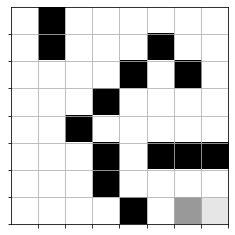

In [57]:
completion_check(model, qmaze)
show(qmaze)

This cell will test your model for one game. It will start the pirate at the top-left corner and run play_game. The agent should find a path from the starting position to the target (treasure). The treasure is located in the bottom-right corner.

We won the game


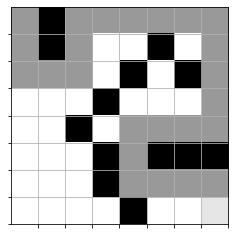

In [58]:
pirate_start = (0, 0)
play_game(model, qmaze, pirate_start)
show(qmaze)

## Save and Submit Your Work
After you have finished creating the code for your notebook, save your work. Make sure that your notebook contains your name in the filename (e.g. Doe_Jane_ProjectTwo.ipynb). This will help your instructor access and grade your work easily. Download a copy of your IPYNB file and submit it to Brightspace. Refer to the Jupyter Notebook in Apporto Tutorial if you need help with these tasks.